# Module

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import cm
from matplotlib.colors import Normalize
import pandas as pd
import seaborn as sns
import pytraj as pt
matplotlib.rcParams.update({'font.size': 22})


# Ternary concentration modulated by ligand binding affinities and cooperativity

In [27]:
colors=['k','b','r','orange','gold']

In [28]:
def CAB(A0,B0,Sf,Ka,Kb,phi=1,):
    R = A0+B0+((Sf+Ka)*(Sf+Kb))/(phi*Sf)
    return (R-np.sqrt(R**2-4*A0*B0))/2

def Cab_S0(A0,B0,Sf,Ka,Kb,phi=1):
    cab = CAB(A0,B0,Sf,Ka,Kb,phi)
    S0 = Sf + (Sf*A0)/(Sf+Ka)+(Sf*B0)/(Sf+Kb)+cab*(1-Sf/(Sf+Ka)-Sf/(Sf+Kb))
    return S0,cab

def Cmax_Kd(A0,B0,Krs,Kls,phi=1):
    # return the maximal f
    R = A0+B0+(np.sqrt(Krs)+np.sqrt(Kls))**2/phi
    return (R-np.sqrt(R**2-4*A0*B0))/2

def find_c50_s50(c,s):
    c_50 =  .5*c.max() # half c.max
    closest_index = None
    closest_difference = float('inf')
    for i, value in enumerate(c):
        difference = abs(value - c_50)
        if difference < closest_difference:
            closest_index = i
            closest_difference = difference
            if value >= c_50:
                break
    return c_50, s[closest_index]

def get_S0opt(A0,B0,Ka,Kb):
    return  (np.sqrt(Ka*Kb) + A0/(1+np.sqrt(Ka/Kb)) + B0/(1+np.sqrt(Kb/Ka))) * 1e6

## Even binding

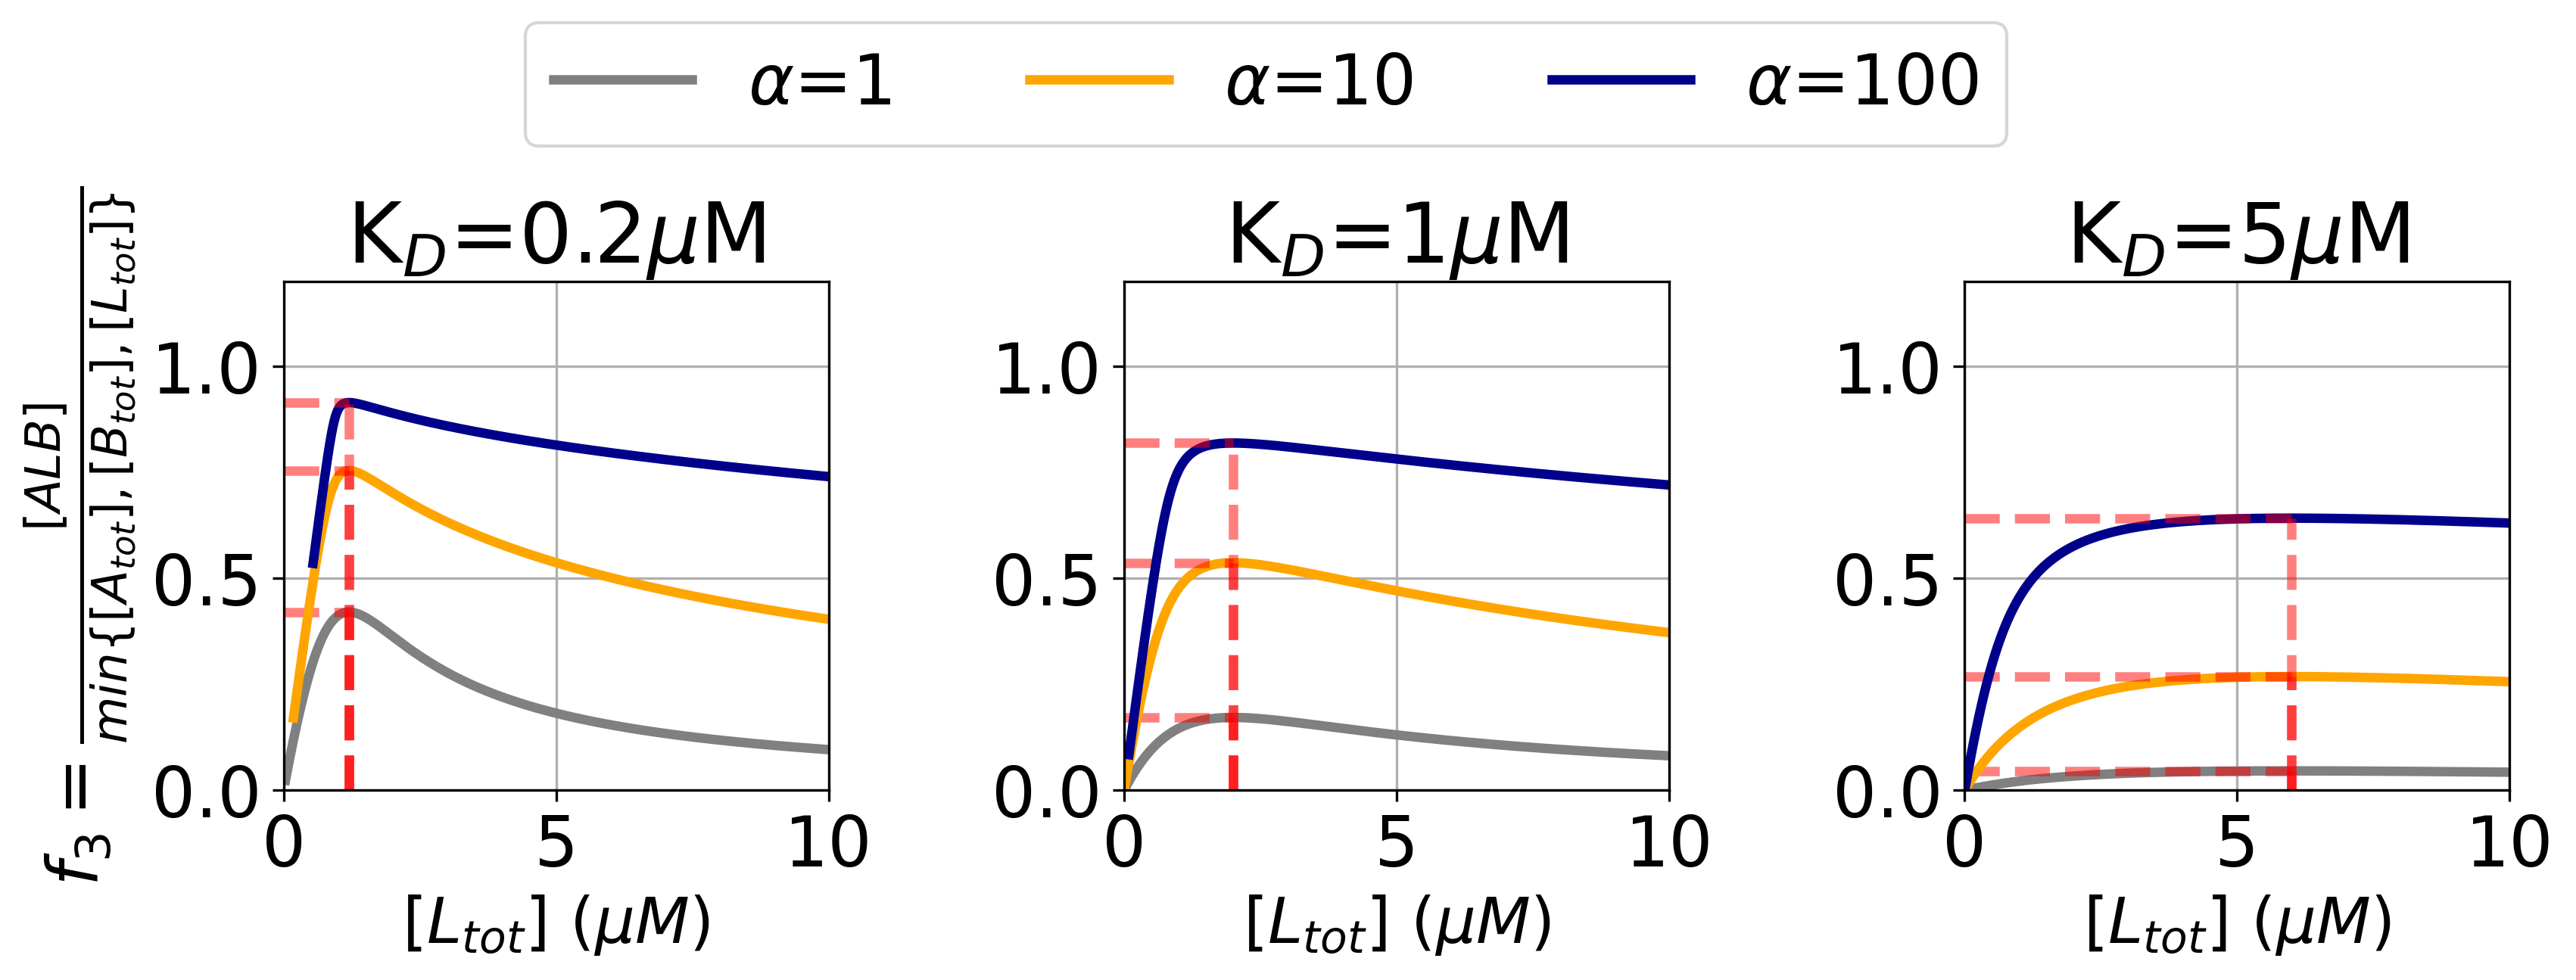

In [32]:
fig, axs = plt.subplots(1,3,figsize=(12,4),dpi=300)
A0=1e-6
B0=1e-6

Kds= [2e-7,1e-6,5e-6]
titles = [r'0.2$\mu$M',r'1$\mu$M',r'5$\mu$M']
colors=['gray','orange','darkblue']
Sf = np.arange(1e-8,1e-5,1e-7)
Sf = 10**(np.arange(-9,-5,0.001))

alphas = [1,10,100]
for i_ax, ax in enumerate(axs):
    for i_alpha, alpha in enumerate(alphas):
        S0,cab = Cab_S0(A0,B0,Sf,Kds[i_ax],Kds[i_ax],phi=alpha)
        # Unit conversion: M to uM
        S0 = S0 * 1e6
        cab = cab * 1e6
        # Get fopt
        max_idx = np.argmax(cab)
        if i_ax == 0:
            label = r'$\alpha$='+str(alpha)
        else:
            label = None
        ax.plot(S0,cab,lw=3,color=colors[i_alpha],label=label)
        ax.plot([S0[max_idx],S0[max_idx]],[0,cab[max_idx]],color='red',ls='--',lw=3,alpha=0.5)
        ax.plot([0,S0[max_idx]],[cab[max_idx],cab[max_idx]],color='red',ls='--',lw=3,alpha=0.5)
    ax.set_xlabel('$[L_{tot}]$ ($\mu M$)',fontsize=20)
    # ax.set_ylabel(r'f ',fontsize=20)
    ax.set_title(r'K$_D$='+titles[i_ax])

    ax.grid()
    
    ax.set_ylim(0,1.2)
    ax.set_xlim(0,10)
    
axs[0].set_ylabel(r'$f_3=\frac{[ALB]}{min\{[A_{tot}],[B_{tot}],[L_{tot}]\}}$')

# Share labels
lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, labels, ncol=3,loc='upper center', bbox_to_anchor = (0, 0.15, 1, 1))
plt.tight_layout()
save_path = './Figures/ALB_Lopt_3alphas.png'
fig.savefig(save_path)

## uneven binding 

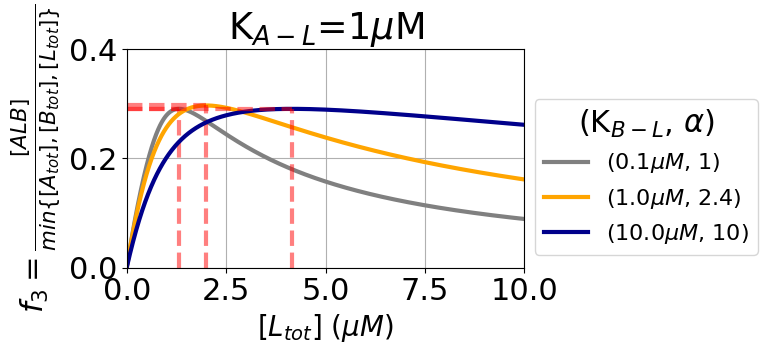

In [6]:
fig, axs = plt.subplots(1,1,figsize=(6,4))
A0=1e-6
B0=1e-6

Ka     = 1e-6
Kbs    = [1e-7,1e-6,1e-5]

alphas = [1,2.4,10] 
title  = '1$\mu$M'

colors=['gray','orange','darkblue']
Sf = np.arange(1e-8,1e-5,1e-7)
Sf = 10**(np.arange(-9,-5,0.001))

ax=axs
for i_alpha, alpha in enumerate(alphas):
    S0,cab = Cab_S0(A0,B0,Sf,Ka,Kbs[i_alpha],phi=alpha)
    # Unit conversion: M to uM
    S0 = S0 * 1e6
    cab = cab /A0
    # Get fopt
    max_idx = np.argmax(cab)
    #label = 'K$_{B-L}$='+str(round(Kbs[i_alpha]*1e6,1), )+ r'$\alpha$='+str(alpha)
    label = '('+str(round(Kbs[i_alpha]*1e6,1))+'$\mu M$, '+str(alpha)+')'
    ax.plot(S0,cab,lw=3,color=colors[i_alpha],label=label)
    ax.plot([S0[max_idx],S0[max_idx]],[0,cab[max_idx]],color='red',ls='--',lw=3,alpha=0.5)
    ax.plot([0,S0[max_idx]],[cab[max_idx],cab[max_idx]],color='red',ls='--',lw=3,alpha=0.5)
ax.set_xlabel('$[L_{tot}]$ ($\mu M$)',fontsize=20)

# ax.set_ylabel(r'f ',fontsize=20)
ax.set_title(r'K$_{A-L}$='+title)

ax.grid()

ax.set_ylim(0,0.4)
ax.set_xlim(0,10)
    
ax.set_ylabel(r'$f_3=\frac{[ALB]}{min\{[A_{tot}],[B_{tot}],[L_{tot}]\}}$')

# Share labels
lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, labels, ncol=1,loc='center right', fontsize=16,
           bbox_to_anchor = (0.32, 0.0, 1, 1), title=r'(K$_{B-L}$, $\alpha$)')
plt.tight_layout()
save_path = './Figures/ALB_Lopt_3alphas_uneven.svg'
fig.savefig(save_path)

## 2D map ($K_{L-B}$ and $\alpha$ )

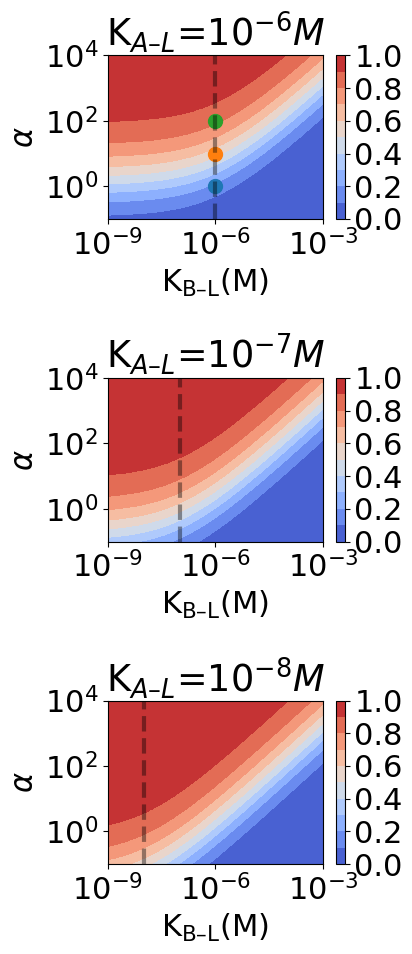

In [31]:
fig, axs = plt.subplots(3,1,figsize=(4.5,10))
# Nomarlize
norm = Normalize(vmin=0, vmax=1)
# [Atot] = [Btot] = 1uM
A0=1e-6
B0=A0

KdAs = [1e-6,1e-7,1e-8]
titles = [r'K$_{A–L}$=$10^{'+str(i)+'} M$' for i in [-6,-7,-8]]
# varying binder to B
log_KdBs = np.arange(-9,-2.9,0.1)
KdBs     = 10**(log_KdBs)

# alpha 
log_phis = np.arange(-1,4.1,0.1)
phis     = 10**(log_phis)


for i_ax, ax in enumerate(axs):
    KdA = KdAs[i_ax]
    # ternary fraction
    fs = np.zeros([len(log_KdBs),len(phis)])
    for i,KdB in enumerate(KdBs):
        fs[i] = Cmax_Kd(A0,B0,KdA,KdB,phis)*1e6
    if i_ax ==0:
        for j in [1,10,100]:
            ax.plot(1e-6,j,marker='o',ms=10)
    # meshgrid
    xi, yi = np.meshgrid(KdBs, phis)
    m = ax.contourf(xi, yi, fs.T, vmin=fs.min(), vmax=fs.max(), origin='lower', cmap=cm.coolwarm, 
                    levels=np.linspace(0,1,11),norm=norm) 
    ax.plot([KdA,KdA],[phis.min(),phis.max()],'k--', alpha=0.4,lw=3)
    plt.colorbar(m, boundaries=np.linspace(0,1,11))
    # ax.set_yticks(np.arange(0,15.1,5))
    # plt.xticks(np.arange(-9,-2.9,2))
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_yticks([1,100,10000])
    ax.set_title(titles[i_ax])
    # ax.set_ylabel(r'Cooperativity $\alpha$')
    ax.set_ylabel(r'$\alpha$')
    ax.set_xlabel(r'K$\rm _{B–L} (M)$')
    
plt.tight_layout()
save_path = './Figures/Cooperativity_2D_exp.svg'
plt.savefig(save_path)

1
10
100


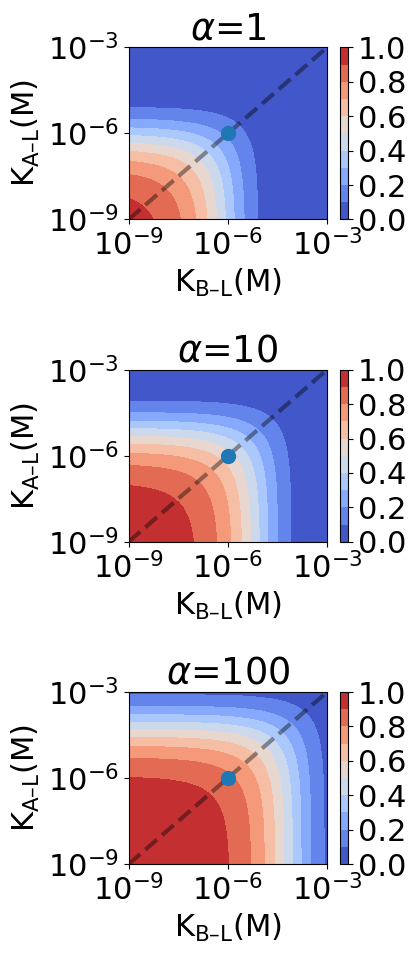

In [32]:
fig, axs = plt.subplots(3,1,figsize=(4.5,10))
# marker_colors = ['']
# Nomarlize
norm = Normalize(vmin=0, vmax=1)
# [Atot] = [Btot] = 1uM
A0=1e-6
B0=A0

phis   = [1,10,100] 
titles = [r'$\alpha$='+str(i) for i in phis]

# varying binder to B
log_KdAs = np.arange(-9,-2.9,0.1)
KdAs     = 10**(log_KdAs)
KdBs     = KdAs 
# alpha 
# phis = np.arange(0.1,15.1,0.1)

for i_ax, ax in enumerate(axs):
    phi = phis[i_ax]
    print(phi)
    # ternary fraction
    fs = np.zeros([len(KdAs),len(KdBs)])
    for i,KdB in enumerate(KdBs):
        fs[i] = Cmax_Kd(A0,B0,KdAs,KdB,phi)*1e6

    # meshgrid
    xi, yi = np.meshgrid(KdAs, KdBs)
    m = ax.contourf(xi, yi, fs.T, vmin=fs.min(), vmax=fs.max(), origin='lower', cmap=cm.coolwarm, 
                    levels=np.linspace(0,1,11),norm=norm) 
    ax.plot([KdAs.min(),KdAs.max()],[KdAs.min(),KdAs.max()],'k--', alpha=0.4,lw=3)
    ax.plot(1e-6,1e-6,marker='o',ms=10)
    plt.colorbar(m, boundaries=np.linspace(0,1,11))
    #ax.set_yticks(np.arange(0,15.1,5))
    plt.xticks(np.arange(-9,-2.9,2))
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_title(titles[i_ax])
    ax.set_xticks([1e-9,1e-6,1e-3])
    ax.set_yticks([1e-9,1e-6,1e-3])

    # ax.set_ylabel(r'Cooperativity $\alpha$')
    #if i_ax ==0:
    ax.set_ylabel(r'K$\rm _{A–L} (M)$')
    ax.set_xlabel(r'K$\rm _{B–L} (M)$')
    
plt.tight_layout()
save_path = './Figures/Kd_2D.svg'
plt.savefig(save_path)

## Plot with equilibrium constant instead

1
10
100


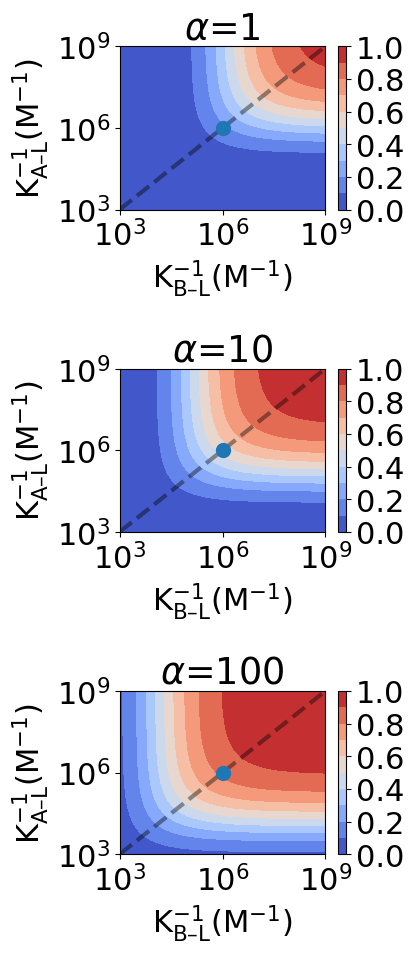

In [33]:
fig, axs = plt.subplots(3,1,figsize=(4.5,10))
# marker_colors = ['']
# Nomarlize
norm = Normalize(vmin=0, vmax=1)
# [Atot] = [Btot] = 1uM
A0=1e-6
B0=A0

phis   = [1,10,100] 
titles = [r'$\alpha$='+str(i) for i in phis]

# varying binder to B
log_KdAs = np.arange(-9,-2.9,0.1)
KdAs     = 10**(log_KdAs)
KdBs     = KdAs 
# Equilibrium constant for A-L binding
KmAs = 1/KdAs
# Equilibrium constant for B-L binding
KmBs = 1/KdBs

for i_ax, ax in enumerate(axs):
    phi = phis[i_ax]
    print(phi)
    # ternary fraction
    fs = np.zeros([len(KmAs),len(KmBs)])
    for i,KmB in enumerate(KmBs):
        fs[i] = Cmax_Kd(A0,B0,1/KmAs,1/KmB,phi)*1e6

    # meshgrid
    xi, yi = np.meshgrid(KmAs, KmBs)
    m = ax.contourf(xi, yi, fs.T, vmin=fs.min(), vmax=fs.max(), origin='lower', cmap=cm.coolwarm, 
                    levels=np.linspace(0,1,11),norm=norm) 
    ax.plot([KmAs.min(),KmAs.max()],[KmAs.min(),KmAs.max()],'k--', alpha=0.4,lw=3)
    ax.plot(1e6,1e6,marker='o',ms=10)
    plt.colorbar(m, boundaries=np.linspace(0,1,11))
    #ax.set_yticks(np.arange(0,15.1,5))
    plt.xticks(np.arange(-9,-2.9,2))
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_title(titles[i_ax])
    # ax.set_xticks([1e-9,1e-6,1e-3])
    # ax.set_yticks([1e-9,1e-6,1e-3])

    # ax.set_ylabel(r'Cooperativity $\alpha$')
    #if i_ax ==0:
    ax.set_ylabel(r'K$\rm _{A–L}^{-1} (M^{-1})$')
    ax.set_xlabel(r'K$\rm _{B–L}^{-1} (M^{-1})$')
    
plt.tight_layout()
save_path = './Figures/Km_2D.svg'
plt.savefig(save_path)

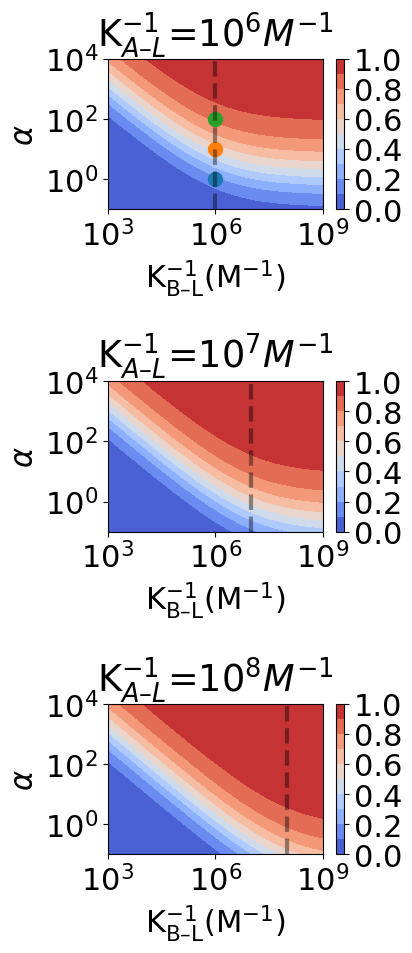

In [34]:
fig, axs = plt.subplots(3,1,figsize=(4.5,10))
# Nomarlize
norm = Normalize(vmin=0, vmax=1)
# [Atot] = [Btot] = 1uM
A0=1e-6
B0=A0

KdAs = [1e-6,1e-7,1e-8]
KmAs = [1e6,1e7,1e8]
# titles = [r'K$_{A–L}$=$10^{'+str(i)+'} M$' for i in [-6,-7,-8]]
titles = [r'K$^{-1}_{A–L}$=$10^{'+str(i)+'} M^{-1}$' for i in [6,7,8]]

# varying binder to B
log_KdBs = np.arange(-9,-2.9,0.1)

KdBs     = 10**(log_KdBs)
KmBs     = 1/KdBs

# alpha 
log_phis = np.arange(-1,4.1,0.1)
phis     = 10**(log_phis)


for i_ax, ax in enumerate(axs):
    KmA = KmAs[i_ax]
    # ternary fraction
    fs = np.zeros([len(KmBs),len(phis)])
    for i,KmB in enumerate(KmBs):
        fs[i] = Cmax_Kd(A0,B0,1/KmA,1/KmB,phis)*1e6
    if i_ax ==0:
        for j in [1,10,100]:
            ax.plot(1e6,j,marker='o',ms=10)
    # meshgrid
    xi, yi = np.meshgrid(KmBs, phis)
    m = ax.contourf(xi, yi, fs.T, vmin=fs.min(), vmax=fs.max(), origin='lower', cmap=cm.coolwarm, 
                    levels=np.linspace(0,1,11),norm=norm) 
    ax.plot([KmA,KmA],[phis.min(),phis.max()],'k--', alpha=0.4,lw=3)
    plt.colorbar(m, boundaries=np.linspace(0,1,11))
    # ax.set_yticks(np.arange(0,15.1,5))
    # plt.xticks(np.arange(-9,-2.9,2))
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_yticks([1,100,10000])
    ax.set_title(titles[i_ax])
    # ax.set_ylabel(r'Cooperativity $\alpha$')
    ax.set_ylabel(r'$\alpha$')
    ax.set_xlabel(r'K$\rm _{B–L}^{-1} (M^{-1})$')
    
plt.tight_layout()
save_path = './Figures/Cooperativity_2D_Km_exp.svg'
plt.savefig(save_path)

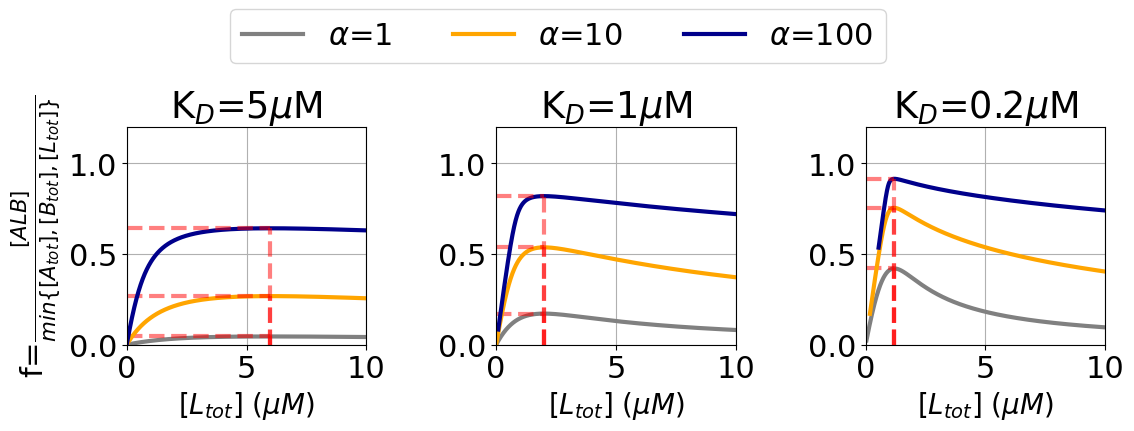

In [35]:
fig, axs = plt.subplots(1,3,figsize=(12,4))
A0=1e-6
B0=1e-6

Kds= [2e-7,1e-6,5e-6]
titles = [r'0.2$\mu$M',r'1$\mu$M',r'5$\mu$M']
# reverse
Kds = Kds[::-1]
titles = titles[::-1]
colors=['gray','orange','darkblue']
Sf = np.arange(1e-8,1e-5,1e-7)
Sf = 10**(np.arange(-9,-5,0.001))

alphas = [1,10,100]
for i_ax, ax in enumerate(axs):
    for i_alpha, alpha in enumerate(alphas):
        S0,cab = Cab_S0(A0,B0,Sf,Kds[i_ax],Kds[i_ax],phi=alpha)
        # Unit conversion: M to uM
        S0 = S0 * 1e6
        cab = cab * 1e6
        # Get fopt
        max_idx = np.argmax(cab)
        if i_ax == 0:
            label = r'$\alpha$='+str(alpha)
        else:
            label = None
        ax.plot(S0,cab,lw=3,color=colors[i_alpha],label=label)
        ax.plot([S0[max_idx],S0[max_idx]],[0,cab[max_idx]],color='red',ls='--',lw=3,alpha=0.5)
        ax.plot([0,S0[max_idx]],[cab[max_idx],cab[max_idx]],color='red',ls='--',lw=3,alpha=0.5)
    ax.set_xlabel('$[L_{tot}]$ ($\mu M$)',fontsize=20)
    # ax.set_ylabel(r'f ',fontsize=20)
    ax.set_title(r'K$_D$='+titles[i_ax])

    ax.grid()
    
    ax.set_ylim(0,1.2)
    ax.set_xlim(0,10)
    
axs[0].set_ylabel(r'f=$\frac{[ALB]}{min\{[A_{tot}],[B_{tot}],[L_{tot}]\}}$')

# Share labels
lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, labels, ncol=3,loc='upper center', bbox_to_anchor = (0, 0.15, 1, 1))
plt.tight_layout()
save_path = './Figures/ALB_Lopt_3alphas_reverse.svg'
fig.savefig(save_path)

# Conformational Free energy

In [36]:
def potential(min,amp,x,k):
    return 0.5*k*(x-min)**2 + amp

def EDS_potential(x,mins,amps,ks, beta=1,tau=1,s=1):
    # mins, amps, ks are arrays of the same length
    # x is a 1D array
    pots = np.array([potential(min,amp,x,k) for min,amp,k in zip(mins,amps,ks)])
    return -np.log(np.sum(np.exp(-beta*pots*s),axis=0))/beta/s * tau


## Allosteric glues

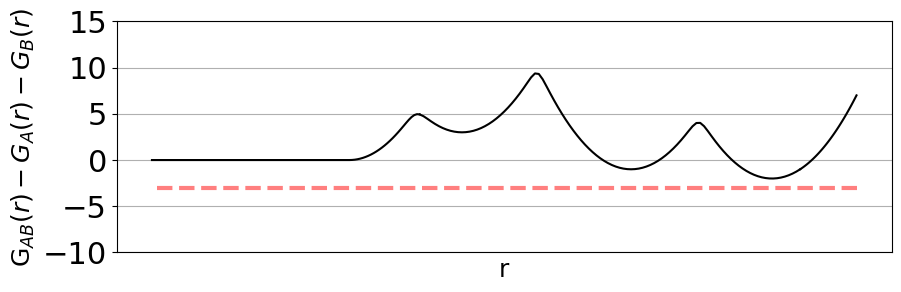

In [37]:
colors = ['black','black','black']
fig = plt.figure(figsize=(10,3))
# x = np.linspace(0,30,100)
mins = [ 13, 18,24,28]
amps = [-2, -1,3,0]
ks   = [2, 2,2,2,6]
xs = [10, 12 ,25.5,35]
for i_ax in range(3):
    x = np.linspace(xs[i_ax],xs[i_ax+1],100)
    y = EDS_potential(x,mins,amps,ks)
    if i_ax == 2:
        xi = np.argmin(abs(x-mins[-1]))
        y[xi:] = 0
    plt.plot(-x,y,color=colors[i_ax])
# Experimental limit
limit = -3
plt.plot([-xs[0],-xs[-1]],[limit,limit],'r--',lw=3,alpha=0.5)
plt.xticks([])
plt.yticks(np.arange(-10,16,5))
plt.grid()
plt.ylabel('G$_{AB}(r)-G_A(r)-G_B(r)$',fontsize=18)
plt.xlabel('r',fontsize=18)
filename='./Figures/AB_allo.svg'
plt.savefig(filename)

## Non-allosteric Glues

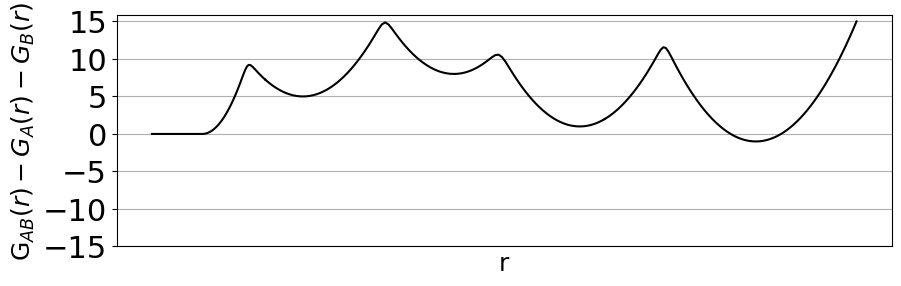

In [38]:
colors = ['black','black','black']
fig = plt.figure(figsize=(10,3))
x = np.linspace(0,30,100)
mins = [6, 13, 18,24,28]
amps = [-1, 1,8,5,0]
ks   = [2, 2,2,2,6]
xs = [2, 12 ,25.5,30]
for i_ax in range(3):
    x = np.linspace(xs[i_ax],xs[i_ax+1],100)
    y = EDS_potential(x,mins,amps,ks)
    if i_ax == 2:
        xi = np.argmin(abs(x-mins[-1]))
        y[xi:] = 0
    plt.plot(-x,y,color=colors[i_ax])
plt.yticks(np.arange(-15,16,5))
plt.xticks([])
plt.grid()
plt.ylabel('G$_{AB}(r)-G_A(r)-G_B(r)$',fontsize=18)
plt.xlabel('r',fontsize=18)
filename='./Figures/AB_non_allo.svg'
plt.savefig(filename)

# PDBbind statistics

In [3]:
df_pdbbind = pd.read_excel('./PDBbind2019.xlsx',skiprows=1)
print(df_pdbbind.head)
Kd_string    = df_pdbbind[df_pdbbind.columns[5]].values
if_Kd = ['Kd' in s for s in df_pdbbind[df_pdbbind.columns[5]].values]
PPI_affinity_all = df_pdbbind[df_pdbbind.columns[6]].values
PPI_affinity_pKd  = PPI_affinity_all[if_Kd]
years        = df_pdbbind[df_pdbbind.columns[7]].values

<bound method NDFrame.head of         ID PDB code   Subset     Complex Type Resolution Affinity Data  \
0        1     1a22  general  Protein-Protein        2.6     Kd=0.34nM   
1        2     1a2k  general  Protein-Protein        2.5      Kd=150nM   
2        3     1a3b  general  Protein-Protein        1.8      Kd=0.3nM   
3        4     1a4y  general  Protein-Protein          2        Ki=1fM   
4        5     1acb  general  Protein-Protein          2      Kd=0.2nM   
...    ...      ...      ...              ...        ...           ...   
2847  2848     6um5  general  Protein-Protein        4.2      Kd=532nM   
2848  2849     6umt  general  Protein-Protein       1.99      Kd=2.6nM   
2849  2850     6uvo  general  Protein-Protein        2.9      Kd=579pM   
2850  2851     6uys  general  Protein-Protein       1.59      Kd=1.6uM   
2851  2852     6uyu  general  Protein-Protein       1.66      Kd=2.0uM   

      pKd pKi pIC50  Release Year  \
0              9.47          1998   
1      

In [4]:
print(np.min(years),np.max(years))

1981 2019


/localhome/shuchen/.conda/envs/py310/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/localhome/shuchen/.conda/envs/py310/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


avg:-9.547917809490727
std:2.4970426086817894
ratio stronger than 10mM 0.9988545246277205
ratio stronger than 1 mu M 0.7014127529591447


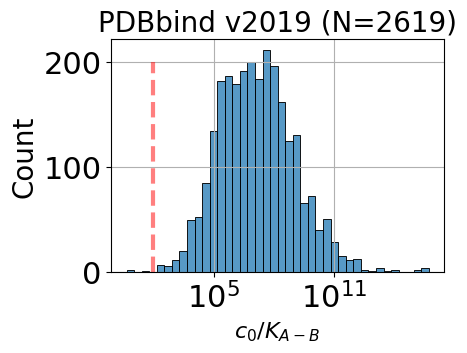

In [7]:
fig = plt.figure(figsize=(5,4))
affinity = PPI_affinity_pKd*-0.58*np.log(10)
PPI_affinity_Kd = 10**(PPI_affinity_pKd)
# sns.histplot(affinity)
sns.histplot(PPI_affinity_Kd,log_scale=True)
plt.grid()
#plt.xlabel(r'pKd/pKi/pIC50 * -$\rm \beta ^{-1} ln(10)$ (kcal/mol)',fontsize=16)
#plt.xlabel(r' $\rm \Delta G_{A-B}$ (kcal/mol)',fontsize=16)
plt.xlabel(r'$ c_0/K_{A-B}$ ',fontsize=16)
# plt.xscale('log')
plt.title('PDBbind v2019 (N='+str(len(affinity))+')',fontsize=20)
plt.ylabel('Count',fontsize=20)
print('avg:'+str(np.average(affinity)))
print('std:'+str(np.std(affinity)))
# plt.xticks(np.arange(-20,1,5))
# Experimental limit
limit = 100
print('ratio stronger than 10mM',np.average(PPI_affinity_Kd > 100))
print('ratio stronger than 1 mu M',np.average(PPI_affinity_Kd > 1000000))
plt.plot([limit,limit],[0,200],'r--',lw=3,alpha=0.5)
plt.tight_layout()
# plt.savefig('./Figures/PPI_Kd_statistics.svg')

/localhome/shuchen/.conda/envs/py310/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/localhome/shuchen/.conda/envs/py310/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


avg:-9.678347896877861
std:2.5381804495072813


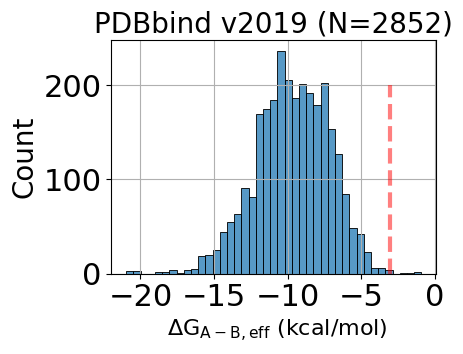

In [8]:
fig = plt.figure(figsize=(5,4))
affinity = PPI_affinity_all*-0.58*np.log(10)
sns.histplot(affinity)
plt.grid()
plt.xlabel(r' $\rm \Delta G_{A-B,eff}$ (kcal/mol)',fontsize=16)
plt.title('PDBbind v2019 (N='+str(len(affinity))+')',fontsize=20)
plt.ylabel('Count',fontsize=20)
print('avg:'+str(np.average(affinity)))
print('std:'+str(np.std(affinity)))
plt.xticks(np.arange(-20,1,5))
limit = -3
plt.plot([limit,limit],[0,200],'r--',lw=3,alpha=0.5)
plt.tight_layout()
plt.savefig('./Figures/PPI_all_statistics.svg')

## Comparing ligands and AB binding pose in Ternary complexes

In [9]:
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Descriptors


In [10]:
#              
PDBIDs     =  [ ['3m50','3m51'], ['5j8o','5j89'], ['6td3','8bug'], ['6hay','6hr2'], # no movement
                ['7jto','7jtp'], ['6bn7','6bnb'],['6w7o','6w8i'],['1fap','8ppz']] # with movement
                
ligand_smis = [ ['CC(C)C[C@@H](C(=O)O)NC(=O)[C@@H]([C@@H](Cc1ccccc1)N)O', # 3m50
                 'c1ccc(cc1)C(=O)C2=C(C(=O)N([C@H]2c3ccc(cc3)[N+](=O)[O-])c4ccc(c(c4)C(=O)O)O)O'], # 3m51
                 ['Cc1c(cccc1c2ccccc2)COc3ccc(cc3Br)CN4CCCC[C@@H]4C(=O)O', # 5j8o
                 'Cc1c(cccc1c2ccccc2)COc3ccc(c(n3)OC)CNCCNC(=O)C'],  # 5j89
                 ['CC[C@H](CO)Nc1nc(c2c(n1)n(cn2)C(C)C)NCc3ccc(cc3)c4ccccn4', # 6td3
                 'Cc1cccc(n1)Nc2nc(cs2)CC(=O)Nc3ncc(s3)C'], # 8bug
                 ['Cc1c(scn1)c2ccc(c(c2)OCCOCCOCCN3CCN(CC3)c4cc(nnc4N)c5ccccc5O)CNC(=O)[C@@H]6C[C@H](CN6C(=O)[C@H](C(C)(C)C)NC(=O)C7(CC7)F)O', # 6hay
                 'Cc1c(scn1)c2ccc(c(c2)OCCc3ccc(cc3)CN4CCN(CC4)c5cc(nnc5N)c6ccccc6O)CNC(=O)[C@@H]7C[C@H](CN7C(=O)[C@H](C(C)(C)C)NC(=O)C8(CC8)F)O'], # 6hr2


                 ['Cc1c(scn1)c2ccc(cc2)CNC(=O)[C@@H]3C[C@H](CN3C(=O)[C@H](C(C)(C)C)NC(=O)CCCCCCCCCC(=O)NCCN4CCN(CC4)Cc5cccc(c5)c6ccc(c(c6)NC(=O)C7=C(CC(=O)N=C7)C(F)(F)F)N8CCN(CC8)C)O', # 7jto
                 'Cc1c(scn1)c2ccc(cc2)[C@H](C)NC(=O)[C@@H]3C[C@H](CN3C(=O)[C@H](C(C)(C)C)NC(=O)CNC(=O)c4ccc(c(c4)c5ccc(c(c5)NC(=O)C6=CNC(=O)C=C6C(F)(F)F)N7C[C@H](N([C@H](C7)C)C)C)F)O'], # 7jtp

                 ['Cc1c2c(sc1C(=O)NCCCCCCCCNC(=O)COc3cccc4c3C(=O)N(C4=O)[C@H]5CCC(=O)NC5=O)-n6c(nnc6[C@@H](N=C2c7ccc(cc7)Cl)CC(=O)OC)C', # 6bn7
                 'O=C(NCCNC1=CC=CC(C(N2C(CC3)C(NC3=O)=O)=O)=C1C2=O)C[C@H]4C5=NN=C(C)N5C6=C(C(C)=C(C)S6)C(C7=CC=C(Cl)C=C7)=N4'], # 6bnb
                ['	C[C@@H](C(=O)N[C@H](C(=O)N1Cc2cc(ccc2C[C@H]1C(=O)N[C@@H]3CCCc4c3cccc4)OCc5cnc(cn5)COC(=O)N6CCC[C@H](C6)n7c(c(c(n7)c8ccc(cc8)Oc9ccc(cc9F)F)C(=O)N)N)C(C)(C)C)NC', # 6w7o
                 'C[C@@H](C(=O)N[C@H](C(=O)N1Cc2cc(ccc2C[C@H]1C(=O)N[C@@H]3CCCc4c3cccc4)OCCOCCOCCOCCOCCOC(=O)N5CCC[C@H](C5)n6c(c(c(n6)c7ccc(cc7)Oc8ccc(cc8F)F)C(=O)N)N)C(C)(C)C)NC'], # 6w8i
                 ['C[C@@H]1CC[C@H]2C[C@@H](C(=CC=C\C=C\[C@H](C[C@H](C(=O)[C@@H]([C@@H](/C(=C/[C@H](C(=O)C[C@H](OC(=O)[C@@H]3CCCCN3C(=O)C(=O)[C@@]1(O2)O)[C@H](C)C[C@@H]4CC[C@H]([C@@H](C4)OC)O)C)/C)O)OC)C)C)C)OC', # 1fap
                 'c1ccc(c(c1)/C=C/[C@H]2CN(C(=O)[C@@H]3CCC[C@H]2N3S(=O)(=O)c4cc(cc(c4)Cl)Cl)Cc5ccccn5)Cl'] # 8ppz
                 ]

In [11]:
#              
PDBIDs     =  [ ['3m50','3m51'], ['5j8o','5j89'], ['6td3','8bug'], ['6hay','6hr2'], # no movement
                ['7jto','7jtp'], ['6bn7','6bnb'],['6w7o','6w8i'],['1fap','8ppz']] # with movement
                
ligand_smis = [ ['CC(C)C[C@@H](C(=O)O)NC(=O)[C@@H]([C@@H](Cc1ccccc1)N)O', # 3m50
                 'c1ccc(cc1)C(=O)C2=C(C(=O)N([C@H]2c3ccc(cc3)[N+](=O)[O-])c4ccc(c(c4)C(=O)O)O)O'], # 3m51
                 ['Cc1c(cccc1c2ccccc2)COc3ccc(cc3Br)CN4CCCC[C@@H]4C(=O)O', # 5j8o
                 'Cc1c(cccc1c2ccccc2)COc3ccc(c(n3)OC)CNCCNC(=O)C'],  # 5j89
                 ['CC[C@H](CO)Nc1nc(c2c(n1)n(cn2)C(C)C)NCc3ccc(cc3)c4ccccn4', # 6td3
                 'Cc1cccc(n1)Nc2nc(cs2)CC(=O)Nc3ncc(s3)C'], # 8bug
                 ['Cc1c(scn1)c2ccc(c(c2)OCCOCCOCCN3CCN(CC3)c4cc(nnc4N)c5ccccc5O)CNC(=O)[C@@H]6C[C@H](CN6C(=O)[C@H](C(C)(C)C)NC(=O)C7(CC7)F)O', # 6hay
                 'Cc1c(scn1)c2ccc(c(c2)OCCc3ccc(cc3)CN4CCN(CC4)c5cc(nnc5N)c6ccccc6O)CNC(=O)[C@@H]7C[C@H](CN7C(=O)[C@H](C(C)(C)C)NC(=O)C8(CC8)F)O'], # 6hr2


                 ['Cc1c(scn1)c2ccc(cc2)CNC(=O)[C@@H]3C[C@H](CN3C(=O)[C@H](C(C)(C)C)NC(=O)CCCCCCCCCC(=O)NCCN4CCN(CC4)Cc5cccc(c5)c6ccc(c(c6)NC(=O)C7=C(CC(=O)N=C7)C(F)(F)F)N8CCN(CC8)C)O', # 7jto
                 'Cc1c(scn1)c2ccc(cc2)[C@H](C)NC(=O)[C@@H]3C[C@H](CN3C(=O)[C@H](C(C)(C)C)NC(=O)CNC(=O)c4ccc(c(c4)c5ccc(c(c5)NC(=O)C6=CNC(=O)C=C6C(F)(F)F)N7C[C@H](N([C@H](C7)C)C)C)F)O'], # 7jtp

                 ['Cc1c2c(sc1C(=O)NCCCCCCCCNC(=O)COc3cccc4c3C(=O)N(C4=O)[C@H]5CCC(=O)NC5=O)-n6c(nnc6[C@@H](N=C2c7ccc(cc7)Cl)CC(=O)OC)C', # 6bn7
                 'O=C(NCCNC1=CC=CC(C(N2C(CC3)C(NC3=O)=O)=O)=C1C2=O)C[C@H]4C5=NN=C(C)N5C6=C(C(C)=C(C)S6)C(C7=CC=C(Cl)C=C7)=N4'], # 6bnb
                ['	C[C@@H](C(=O)N[C@H](C(=O)N1Cc2cc(ccc2C[C@H]1C(=O)N[C@@H]3CCCc4c3cccc4)OCc5cnc(cn5)COC(=O)N6CCC[C@H](C6)n7c(c(c(n7)c8ccc(cc8)Oc9ccc(cc9F)F)C(=O)N)N)C(C)(C)C)NC', # 6w7o
                 'C[C@@H](C(=O)N[C@H](C(=O)N1Cc2cc(ccc2C[C@H]1C(=O)N[C@@H]3CCCc4c3cccc4)OCCOCCOCCOCCOCCOC(=O)N5CCC[C@H](C5)n6c(c(c(n6)c7ccc(cc7)Oc8ccc(cc8F)F)C(=O)N)N)C(C)(C)C)NC'], # 6w8i
                 ['C[C@@H]1CC[C@H]2C[C@@H](C(=CC=C\C=C\[C@H](C[C@H](C(=O)[C@@H]([C@@H](/C(=C/[C@H](C(=O)C[C@H](OC(=O)[C@@H]3CCCCN3C(=O)C(=O)[C@@]1(O2)O)[C@H](C)C[C@@H]4CC[C@H]([C@@H](C4)OC)O)C)/C)O)OC)C)C)C)OC', # 1fap
                 'c1ccc(c(c1)/C=C/[C@H]2CN(C(=O)[C@@H]3CCC[C@H]2N3S(=O)(=O)c4cc(cc(c4)Cl)Cl)Cc5ccccn5)Cl'] # 8ppz
                 ]

In [12]:
ms = [[Chem.MolFromSmiles(smi) for smi in ligand_smi] for ligand_smi in ligand_smis]
# fpgen = AllChem.GetRDKitFPGenerator()
fpgen = AllChem.GetMorganGenerator(radius=2, fpSize=2048)
fps = [[fpgen.GetFingerprint(m,) for m in ligands] for ligands in ms]
Tanimoto = [AllChem.DataStructs.TanimotoSimilarity(fp[0],fp[1]) for i,fp in enumerate(fps)]
molecular_weights = [[Descriptors.ExactMolWt(lig) for lig in m] for m in ms]

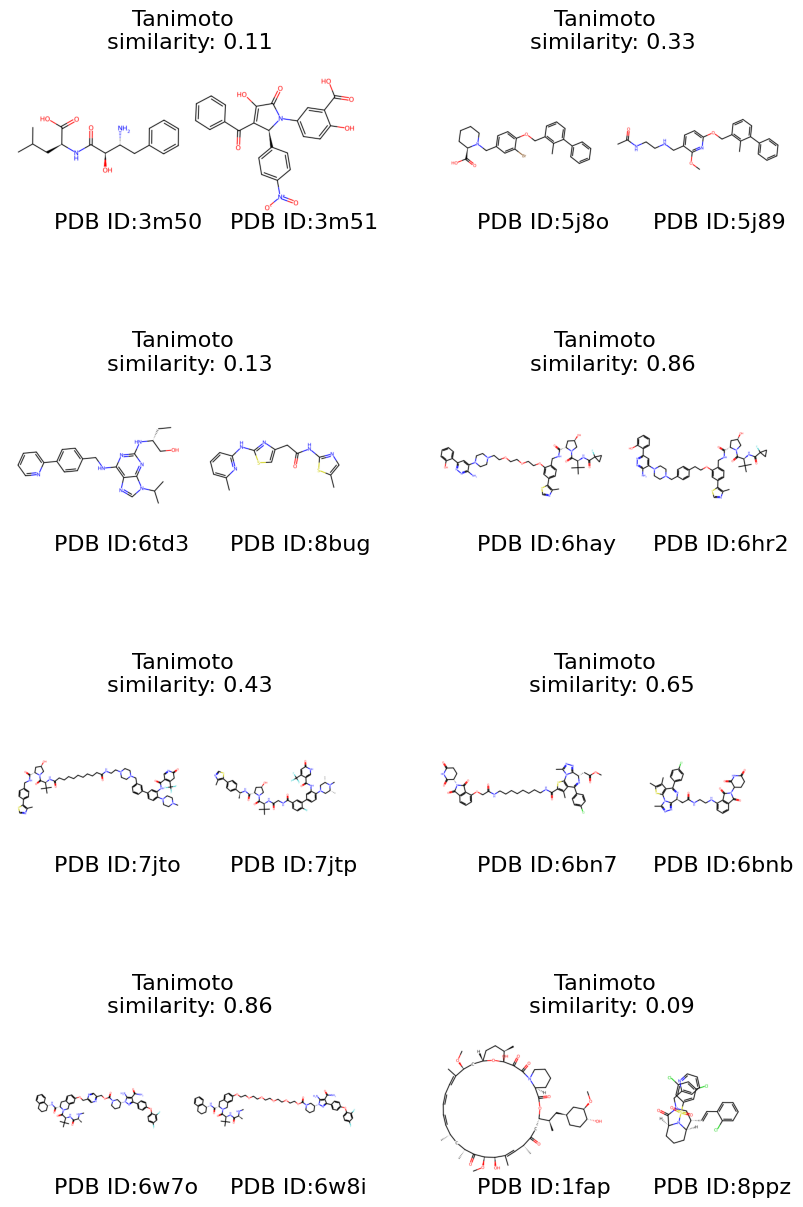

In [14]:
fig, axs = plt.subplots(4,2, figsize=(10,16))
sub_img_size = 400
y_offset = -10
for i, ax in enumerate(axs.flat):
    img = Chem.Draw.MolsToGridImage(ms[i], molsPerRow=2, subImgSize=(sub_img_size,sub_img_size), returnPNG=False)
    ax.axis('off')
    for i_pdbid, pdbid in enumerate(PDBIDs[i]):
        text_pos = (sub_img_size * (1/4+i_pdbid) , sub_img_size+y_offset)
        ax.annotate('PDB ID:'+pdbid,text_pos,fontsize=16)
        # ax.annotate('pdbid:'+pdbid+'\nMW:'+str(round(molecular_weights[i_ax][i_pdbid],2)),text_pos,fontsize=16)
    ax.imshow(img, origin="upper")
    ax.set_title('Tanimoto \n similarity: '+str(round(Tanimoto[i],2)),fontsize=16)
plt.savefig('./Figures/ligand_similarity.svg')
# img = Chem.Draw.MolsToGridImage(ms[i], molsPerRow=2, subImgSize=(400, 400), returnPNG=False,legends=PDBIDs[i])
# ax.axis('off')
# plt.title('Tanimoto similarity: '+str(round(Tanimoto[i],2)))    
# ax.imshow(img, origin="upper")

### COM distance of 3m50 & 3m51 ligands

In [48]:
p_pdb_3m50 = './dimer_trimer/s1-s2/3m50.cif'
p_pdb_3m51 = './dimer_trimer/s1-s2/3m51.cif'
pdb_3m50 = pt.load(p_pdb_3m50)
pdb_3m51 = pt.load(p_pdb_3m51)

In [49]:
com_3m50 = pt.center_of_mass(pdb_3m50,mask=':EBT')
com_3m51 = pt.center_of_mass(pdb_3m51,mask=':YR1')
com_dist = np.linalg.norm(com_3m50-com_3m51)
print('distance between center of mass:',com_dist)

distance between center of mass: 9.851213435039366


## COM distance of 5j8o & 5j89 ligands

In [55]:
p_pdb_5j8o = './dimer_trimer/s1-s2/5j8o.cif'
p_pdb_5j89 = './dimer_trimer/s1-s2/5j89_aligned.pdb'
pdb_5j8o = pt.load(p_pdb_5j8o)
pdb_5j89 = pt.load(p_pdb_5j89)

In [56]:
com_5j8o = pt.center_of_mass(pdb_5j8o,mask=':6GZ')
com_5j89 = pt.center_of_mass(pdb_5j89,mask=':6GX')
com_dist = np.linalg.norm(com_5j8o-com_5j89)
print('distance between center of mass:',com_dist)

distance between center of mass: 12.432784527351274


## COM distance of 6td3 and 8bug

In [58]:
p_pdb_6td3 = './dimer_trimer/s1-s2/6td3_B.pdb'
p_pdb_8bug = './dimer_trimer/s1-s2/8bug_B.pdb'
pdb_6td3 = pt.load(p_pdb_6td3)
pdb_8bug = pt.load(p_pdb_8bug)

In [59]:
com_6td3 = pt.center_of_mass(pdb_6td3,mask=':RC8')
com_8bug = pt.center_of_mass(pdb_8bug,mask=':RPW')
com_dist = np.linalg.norm(com_6td3-com_8bug)
print('distance between center of mass:',com_dist)

distance between center of mass: 1.4595831710402165


## COM distance of 1fap and 8ppz

In [60]:
p_pdb_1fap = './dimer_trimer/s1-s2/1fap_aligned.pdb'
p_pdb_8ppz = './dimer_trimer/s1-s2/8ppz_aligned.pdb'
pdb_1fap = pt.load(p_pdb_1fap)
pdb_8ppz = pt.load(p_pdb_8ppz)

In [61]:
com_1fap = pt.center_of_mass(pdb_1fap,mask=':RAP')
com_8ppz = pt.center_of_mass(pdb_8ppz,mask=':0AN')
com_dist = np.linalg.norm(com_1fap-com_8ppz)
print('distance between center of mass:',com_dist)

distance between center of mass: 4.244494263899018
